# emotion detection

** importing libraries**

In [1]:
import matplotlib.pyplot as plt
from glob import glob  #use to list file in that dir
import cv2
import random
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator #create the form of data for model to understand
from tensorflow.keras.layers import  Dense, Input, Dropout, Flatten
from tensorflow.keras.layers import  BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import Image,SVG
import tensorflow as tf
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.16.1


In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D


**Exploring Dataset**

In [3]:
images = glob("train/**/**")

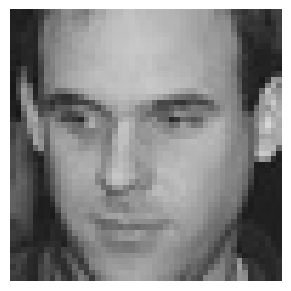

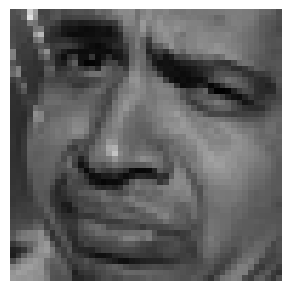

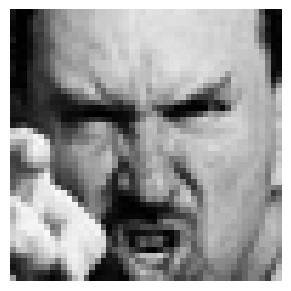

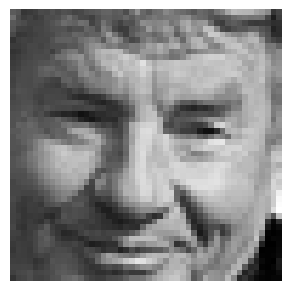

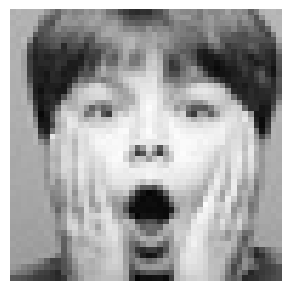

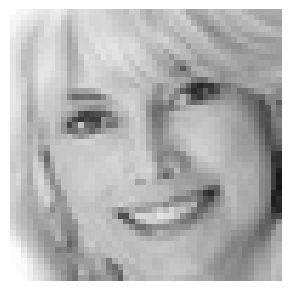

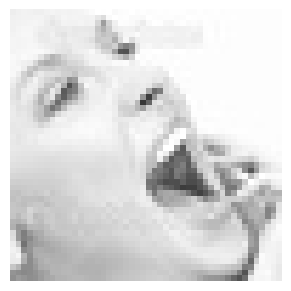

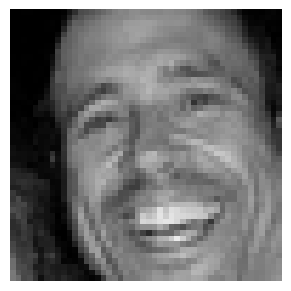

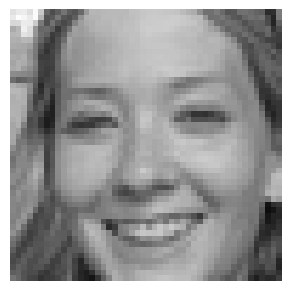

In [4]:
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i) #random number
    plt.imshow(cv2.imread(image));plt.axis('off')



**Preparing Data For Training**

In [6]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/",
target_size=(img_size,img_size),
color_mode="grayscale",
batch_size=batch_size,
class_mode='categorical',shuffle=True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_validation.flow_from_directory("test/",
target_size=(img_size,img_size),
color_mode="grayscale",
batch_size=batch_size,
class_mode='categorical',shuffle=False)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [7]:
def Convolution(input_tensor,filters,kernal_size):# use to decrease image and find the feature
    x = Conv2D(filters=filters,kernel_size=(kernal_size,kernal_size),padding='same')(input_tensor)
    x = BatchNormalization()(x)# remove overfitting and increase the speed of training
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2))(x)# decrease the dimensions of data
    x = Dropout(0.25)(x)# remove overfitting
    return x


In [8]:
def Dense_f(input_tensor,nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    return x

In [11]:
def model_fer(input_shape): #hyperparameter tuning
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs,32,3)# 32 is the number of filters and (3,3) is the size of filter
    conv_2 = Convolution(inputs,64,5)# 64 is the number of filters and (5,5) is the size of filter
    conv_3 = Convolution(inputs,128,3)# 128 is the number of filters and (3,3) is the size of filter

    flatten = Flatten()(conv_3)
    dense_1 = Dense_f(flatten,256)
    output = Dense(7,activation='softmax')(dense_1)# output should be array of size 7  and softmax is used to get the probability of each class
    model = Model(inputs=[inputs],outputs=[output])
    model.compile(loss=['categorical_crossentropy'],optimizer=adam,metrics=['accuracy'])# loss is used to find the error and optimizer is used to reduce the error and metrics is used to find the accuracy of model
    return model

In [15]:
adam = Adam()
model = model_fer((48,48,1))
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Initializing the Model**

In [19]:
epochs=50 # number of iteration
steps_per_epoch = train_generator.n //train_generator.batch_size # number of iteration in each epoch ''' (train_generatpr.n)it gives all the number of images'''
validation_steps = validation_generator.n//validation_generator.batch_size # we use // for int number
checkpoint = ModelCheckpoint("model_weights.weights.h5",monitor='val_accuracy',
                             save_weights_only=True,mode='max',verbose=1)   # it is used to save the model with highest accuracy 
callbacks = [checkpoint] 

# Train the Model

In [20]:
history = model.fit(
    x=train_generator, #training data
    steps_per_epoch=steps_per_epoch, #number of iteration in each epoch
    epochs=epochs, #number of iteration
    validation_data = validation_generator, #validation data
    validation_steps = validation_steps, #number of iteration in each epoch
    callbacks = callbacks #save the model with highest accuracy
) 

Epoch 1/50


c:\Users\harsh\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.3350 - loss: 1.8448
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 309s 677ms/step - accuracy: 0.3351 - loss: 1.8444 - val_accuracy: 0.3836 - val_loss: 1.5957
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:12 430ms/step - accuracy: 0.4531 - loss: 1.3682
Epoch 2: saving model to model_weights.weights.h5


c:\Users\harsh\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4531 - loss: 1.3682 - val_accuracy: 0.2000 - val_loss: 2.5281
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4962 - loss: 1.3403
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 212s 471ms/step - accuracy: 0.4962 - loss: 1.3403 - val_accuracy: 0.4096 - val_loss: 1.5612
Epoch 4/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:20 448ms/step - accuracy: 0.5625 - loss: 1.2010
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5625 - loss: 1.2010 - val_accuracy: 0.2000 - val_loss: 2.6349
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.5584 - loss: 1.1868
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 206s 460ms/step - accuracy: 0.5584 - loss: 1.1868 - val_accuracy: 0.3718 - val_loss: 1.6083
Epoch 6/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 3:04 412ms/step - accuracy: 0.5312 - loss: 1.1907
Epoch 6: saving mo

**Model Evaluation**

In [22]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.4586 - loss: 2.4824


[2.3297019004821777, 0.4909445643424988]

**Plotting Loss**

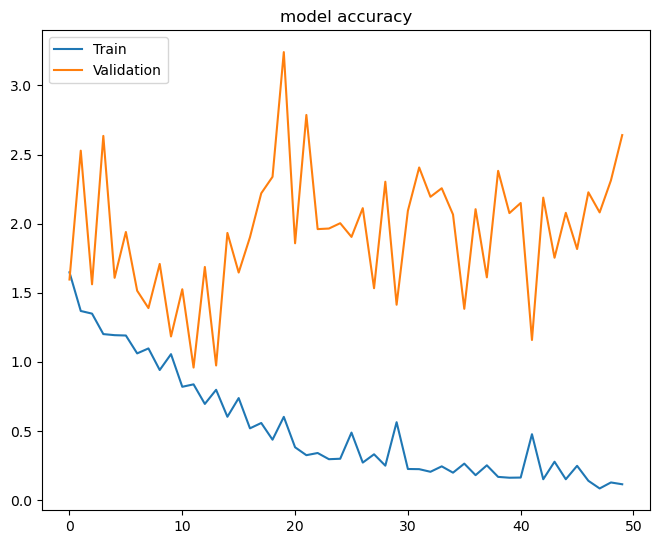

In [35]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) #plot the graph of loss
plt.title('model loss')    
plt.legend(['Train','Validation'],loc='upper left') #legend is used to show the label of each line
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,wspace=0.35,hspace=0.25) #adjust the plot


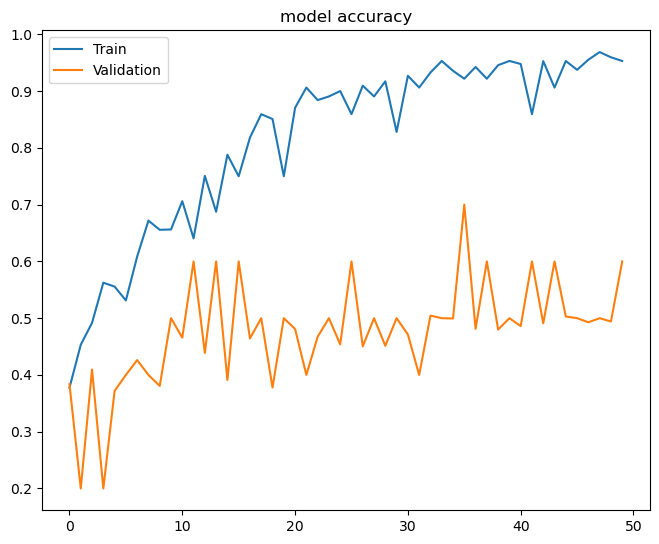

In [36]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) #plot the graph of accuracy
plt.title('model accuracy')    
plt.legend(['Train','Validation'],loc='upper left') #legend is used to show the label of each line
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,wspace=0.35,hspace=0.25) #adjust the plot


**saving model**

In [38]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)